<a href="https://colab.research.google.com/github/uhdang/mlim_group_3_final_assignment/blob/main/quang/FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
# from datastreamer import DataStreamerP2V
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
baskets = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet")
coupons = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parquet")
# coupon_index = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
baskets['target'] = 1
baskets

,week,shopper,product,price,target
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1
...,...,...,...,...,...
68841593,89,99999,143,470,1
68841594,89,99999,158,566,1
68841595,89,99999,186,499,1
68841596,89,99999,204,496,1


In [4]:
coupons

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44999995,89,99999,62,40
44999996,89,99999,110,10
44999997,89,99999,37,40
44999998,89,99999,155,25


In [5]:
#baskets[['week', 'shopper', 'product']] = baskets[['week', 'shopper', 'product']].astype('category')
# baskets[['shopper', 'product']] = baskets[['shopper', 'product']].astype('category')
baskets['product'] = baskets['product'].astype('category')
coupons['product'] = coupons['product'].astype('category')

# Split Data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
weeks = 89 
shoppers = 100

baskets_train = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week<weeks), :]
baskets_test = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week>=weeks), :]

coupons_train = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week<weeks), :]
coupons_test = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week>=weeks), :]

In [8]:
baskets_train['shopper'] = baskets_train['shopper'].astype('category')
coupons_train['shopper'] = coupons_train['shopper'].astype('category')

# baskets_train['target'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
baskets_train

,week,shopper,product,price,target
0,0,0,71,629,1
1,0,0,91,605,1
2,0,0,116,715,1
3,0,0,123,483,1
4,0,0,157,592,1
...,...,...,...,...,...
67312654,88,99,142,551,1
67312655,88,99,176,681,1
67312656,88,99,187,663,1
67312657,88,99,199,604,1


In [10]:
coupons_train

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44000495,88,99,160,40
44000496,88,99,31,40
44000497,88,99,141,15
44000498,88,99,14,30


# Data Preprocessing

In [11]:
# Counting weeks of prior order for each product/customer
# baskets_train['weeks_since_prior_order'] = baskets_train.groupby(['shopper', 'product']).week.apply(lambda x: x.diff()) # change to count weeks since last order, even when it wasn't bought

In [12]:
full_df_train = (baskets_train
           .merge(
               coupons_train, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
          #  .replace(['left_only', 'right_only', 'both'], ['RRP', 'coupon', 'discounted'])
          .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
          .rename(columns={'_merge': 'coupon'})
)

full_df_train.loc[full_df_train['discount'].isna(),'discount' ] = 0

In [13]:
full_df_train

,week,shopper,product,price,target,discount,coupon
0,0,0,5,NaN,NaN,30.0,Yes
1,0,0,27,NaN,NaN,30.0,Yes
2,0,0,35,NaN,NaN,35.0,Yes
3,0,0,71,629.0,1.0,0.0,No
4,0,0,91,605.0,1.0,0.0,No
...,...,...,...,...,...,...,...
109678,88,99,160,NaN,NaN,40.0,Yes
109679,88,99,176,681.0,1.0,0.0,No
109680,88,99,187,663.0,1.0,0.0,No
109681,88,99,199,604.0,1.0,0.0,No


In [14]:
# offered_price = 
original_price = baskets.groupby('product', as_index=False).price.max().rename(columns={'price': 'original_price'})
total_count_of_product = baskets_train.groupby(['shopper', 'product']).product.count().to_frame('total_count_of_product').reset_index()
reordered = (baskets_train.groupby(['shopper']).product.value_counts()>1).astype(int)
average_price_per_shopper = baskets_train.groupby(['shopper']).price.mean().to_frame('average_price_per_shopper').reset_index()
average_basket_size = baskets_train.groupby(['shopper', 'week']).product.count().groupby('shopper').mean().to_frame('average_basket_size').reset_index()
unique_products_per_shopper = baskets_train.groupby(['shopper']).product.nunique()
ratio_of_reordered_per_shopper = (reordered.groupby('shopper').sum() / unique_products_per_shopper).to_frame('ratio_of_reordered').reset_index()

ratio_of_reordered_per_product = total_count_of_product.copy()
ratio_of_reordered_per_product['total_count_of_product'] = total_count_of_product['total_count_of_product'] / (baskets_train.week.max()+1)
ratio_of_reordered_per_product.rename(columns={'total_count_of_product': 'ratio_of_reordered_per_product'}, inplace=True)

reordered = reordered.to_frame('reordered').reset_index()
unique_products_per_shopper = unique_products_per_shopper.to_frame('unique_products_per_shopper').reset_index()

# add average interval for each product and shopper
# WoE

# Set Up Training Table

In [15]:
df1 = pd.DataFrame({'key':np.ones(weeks), 'week':list(range(weeks))})
df2 = pd.DataFrame({'key':np.ones(shoppers), 'shopper':list(range(shoppers))})
df3 = pd.DataFrame({'key':np.ones(250), 'product':list(range(250))})
df4 = full_df_train.copy()

X_train = pd.merge(df1, df2, on='key').merge(df3, on='key').merge(df4, on=['week', 'shopper', 'product'], how='left')[full_df_train.columns]

In [16]:
X_train

,week,shopper,product,price,target,discount,coupon
0,0,0,0,NaN,NaN,NaN,NaN
1,0,0,1,NaN,NaN,NaN,NaN
2,0,0,2,NaN,NaN,NaN,NaN
3,0,0,3,NaN,NaN,NaN,NaN
4,0,0,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2224995,88,99,245,NaN,NaN,NaN,NaN
2224996,88,99,246,NaN,NaN,NaN,NaN
2224997,88,99,247,NaN,NaN,NaN,NaN
2224998,88,99,248,NaN,NaN,NaN,NaN


Combine everything

In [17]:
X_train = (X_train
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           )

In [18]:
X_train

,week,shopper,product,price,target,discount,coupon,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper
0,0,0,0,NaN,NaN,NaN,NaN,688,0,NaN,0.000000,0.722222,587.203947,8.539326,54
1,0,0,1,NaN,NaN,NaN,NaN,560,0,NaN,0.000000,0.722222,587.203947,8.539326,54
2,0,0,2,NaN,NaN,NaN,NaN,773,0,NaN,0.000000,0.722222,587.203947,8.539326,54
3,0,0,3,NaN,NaN,NaN,NaN,722,0,NaN,0.000000,0.722222,587.203947,8.539326,54
4,0,0,4,NaN,NaN,NaN,NaN,620,8,1.0,0.089888,0.722222,587.203947,8.539326,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224995,88,99,245,NaN,NaN,NaN,NaN,549,0,NaN,0.000000,0.763158,618.717752,8.797753,76
2224996,88,99,246,NaN,NaN,NaN,NaN,702,41,1.0,0.460674,0.763158,618.717752,8.797753,76
2224997,88,99,247,NaN,NaN,NaN,NaN,670,0,NaN,0.000000,0.763158,618.717752,8.797753,76
2224998,88,99,248,NaN,NaN,NaN,NaN,490,0,NaN,0.000000,0.763158,618.717752,8.797753,76


In [19]:
X_train.isnull().any()

week                              False
shopper                           False
product                           False
price                              True
target                             True
discount                           True
coupon                             True
original_price                    False
total_count_of_product            False
reordered                          True
ratio_of_reordered_per_product    False
ratio_of_reordered                False
average_price_per_shopper         False
average_basket_size               False
unique_products_per_shopper       False
dtype: bool

In [20]:
X_train['discount'].fillna(0, inplace=True)
X_train['price'].fillna(X_train.original_price*(1-X_train.discount), inplace=True)
X_train['reordered'].fillna(0, inplace=True)
X_train['coupon'].fillna('No', inplace=True)
# X_train['weeks_since_prior_order'].fillna(0, inplace=True)
X_train['target'].fillna(0, inplace=True)

In [21]:
addkey = X_train.groupby(['shopper','product']).target.apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
X_train['weeks_since_prior_order'] = X_train.target.eq(0).groupby([X_train['shopper'], X_train['product'], addkey]).cumsum()

In [22]:
X_train.head(3)

,week,shopper,product,price,target,discount,coupon,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper,weeks_since_prior_order
0,0,0,0,688.0,0.0,0.0,No,688,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
1,0,0,1,560.0,0.0,0.0,No,560,0,0.0,0.0,0.722222,587.203947,8.539326,54,1
2,0,0,2,773.0,0.0,0.0,No,773,0,0.0,0.0,0.722222,587.203947,8.539326,54,1


In [23]:
X_train.drop('week', inplace=True, axis=1)

In [24]:
y_train = X_train.pop('target')

# Set Up Test Table

In [25]:
full_df_test = (baskets_test
           .merge(
               coupons_test, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
          #  .replace(['left_only', 'right_only', 'both'], ['RRP', 'coupon', 'discounted'])
          .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
          .rename(columns={'_merge': 'coupon'})
)

full_df_test.loc[full_df_test['discount'].isna(),'discount' ] = 0

In [26]:
df1 = pd.DataFrame({'key': np.ones(len(baskets_test.week.unique())), 'week': baskets_test.week.unique()})
df2 = pd.DataFrame({'key': np.ones(shoppers), 'shopper': list(range(shoppers))})
df3 = pd.DataFrame({'key': np.ones(250), 'product': list(range(250))})
df4 = full_df_test.copy()

X_test = pd.merge(df1, df2, on='key').merge(df3, on='key').merge(df4, on=['week', 'shopper', 'product'], how='left')[full_df_test.columns]

In [27]:
X_test = (X_test
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(ratio_of_reordered_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           )

In [28]:
X_test['discount'].fillna(0, inplace=True)
X_test['price'].fillna(X_test.original_price*(1-X_test.discount), inplace=True)
X_test['reordered'].fillna(0, inplace=True)
X_test['coupon'].fillna('No', inplace=True)
# X_train['weeks_since_prior_order'].fillna(0, inplace=True)
X_test['target'].fillna(0, inplace=True)

In [29]:
last_weeks_since_prior_order = X_train.groupby(['shopper', 'product']).weeks_since_prior_order.last() + 1

In [30]:
X_test = X_test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

In [31]:
X_test.drop('week', inplace=True, axis=1)

In [32]:
y_test = X_test.pop('target')

# One-Hot Encoding Products

In [61]:
from sklearn.preprocessing import OneHotEncoder

In [62]:
enc = OneHotEncoder(sparse=False)

encodings = X_train.select_dtypes(exclude=np.number).columns.tolist()
# encoded = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(X_train[encodings]))
encoded = pd.DataFrame(enc.fit_transform(X_train[encodings]))
encoded.columns = enc.get_feature_names(encodings)

X_train = pd.concat([X_train, encoded], axis=1).drop(encodings, axis=1)

In [63]:
X_train = X_train.apply(pd.to_numeric)

In [64]:
X_train.head(3)

,price,discount,original_price,total_count_of_product,reordered,ratio_of_reordered_per_product,ratio_of_reordered,average_price_per_shopper,average_basket_size,unique_products_per_shopper,weeks_since_prior_order,shopper_0,shopper_1,shopper_2,shopper_3,shopper_4,shopper_5,shopper_6,shopper_7,shopper_8,shopper_9,product_0,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9,product_10,product_11,product_12,product_13,product_14,product_15,product_16,product_17,product_18,...,product_212,product_213,product_214,product_215,product_216,product_217,product_218,product_219,product_220,product_221,product_222,product_223,product_224,product_225,product_226,product_227,product_228,product_229,product_230,product_231,product_232,product_233,product_234,product_235,product_236,product_237,product_238,product_239,product_240,product_241,product_242,product_243,product_244,product_245,product_246,product_247,product_248,product_249,coupon_No,coupon_Yes
0,688.0,0.0,688,0,0.0,0.0,0.735849,588.0631,8.576471,53,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,560.0,0.0,560,0,0.0,0.0,0.735849,588.0631,8.576471,53,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,773.0,0.0,773,0,0.0,0.0,0.735849,588.0631,8.576471,53,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Training

In [33]:
import lightgbm as lgb

In [34]:
from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

lgb_clf = lgb.LGBMClassifier(
    scale_pos_weight=1 #estimate
    )

In [35]:
categorical = X_train.select_dtypes(exclude=np.number).columns.tolist()
for cats in categorical:
  X_train[cats] = X_train[cats].astype('category')
  X_test[cats] = X_test[cats].astype('category')

In [46]:
lgb_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [47]:
lgb_clf.score(X_train, y_train)

0.9791622471910112

In [48]:
lgb_clf.score(X_test, y_test)

0.97256

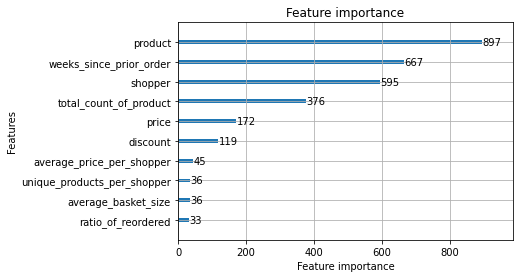

In [49]:
lgb.plot_importance(lgb_clf, max_num_features=10)

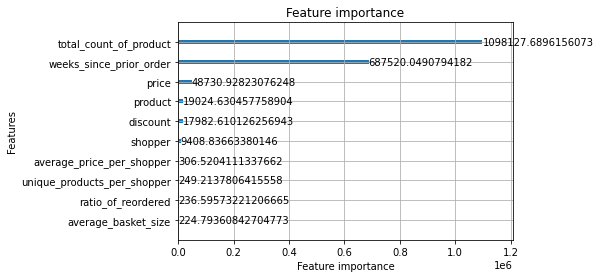

In [50]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

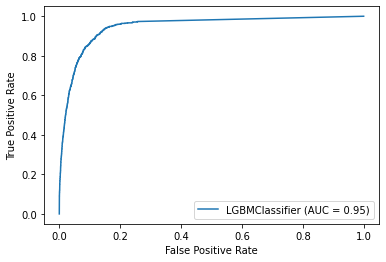

In [51]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(estimator=lgb_clf, X=X_test, y=y_test)

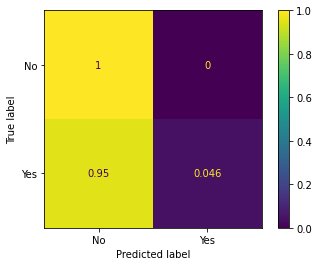

In [52]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [53]:
confusion

array([[24281,     0],
       [  686,    33]])

In [54]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [55]:
print(f'TPR: {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')
print(f'Precision: {PPV:.4f}')
print(f'False discovery rate: {FDR:.4f}')

TPR: 0.0459
TNR: 1.0000
FPR: 0.0000
FNR: 0.9541
Precision: 1.0000
False discovery rate: 0.0000
